A notebook for generating the final results for a fully cross-validated transfer analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib
import re

import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.utils.file_system import get_immediate_subfolders

In [3]:
%matplotlib notebook

## Parameters go here

In [17]:
# A list of of base_folders with the results of different analyses.  A single analysis consists of 
# runing the full cross-validated results with multiple amounts of training data for models fit
# both individually and combined, with a *single* set of parameters.  In this convention, we could 
# run different analyses using different numbers of hypercubes in the prior, for example, and then compare results. 

base_folders = [r'/groups/bishop/bishoplab/projects/probabilistic_model_synthesis/results/real_data/gnldr/same_cond_transfer_analysis/v0']

# The names of files holding post-processed results for each type of analysis
results_files = ['pp_test_results.pt']

# Subjects we want to evaluate performance on
eval_subjs = [8, 9, 10, 11]

subj_clrs = np.asarray([[1.0, 0.0, 0.0],
                        [0.0, 1.0, 0.0], 
                        [0.0, 0.0, 1.0], 
                        [1.0, 1.0, 0.0]])

# Training quantities we want to evaluate performance on
tq_strings = ['fold_str_base_14_tgt_1', 
              'fold_str_base_14_tgt_2',
              'fold_str_base_14_tgt_4',
              'fold_str_base_14_tgt_8',
              'fold_str_base_14_tgt_14']

tq_fracs = np.asarray([1.0/14, 
                       2.0/14, 
                       4.0/14,
                       8.0/14,
                       14.0/14.0])


## Define helper functions here

In [5]:
def get_analysis_results(base_folder, results_file, fit_type: str = 'ip', data_type: str = 'test'):
    training_quantity_folders = get_immediate_subfolders(base_folder)
    training_quantity_folders = tq_strings
    tq_rs = dict()
    for tq_folder in training_quantity_folders:
        #print('TQ folder: ' + tq_folder)
        tq_folder_path = pathlib.Path(base_folder) / tq_folder
        fold_folders = get_immediate_subfolders(tq_folder_path)
        n_folds = len(fold_folders)
        fold_rs = dict()
        for fold_folder in fold_folders:
            cur_fold = int(re.match('.*_(\d*)', fold_folder)[1])
            #print('Fold: ' + str(cur_fold))
            fold_folder_path = pathlib.Path(tq_folder_path) / fold_folder
            subj_folders = get_immediate_subfolders(fold_folder_path)
            n_subjs = len(subj_folders)
            subj_rs = dict()
            for subj_folder in subj_folders:
                #print('Subject folder: ' + subj_folder)
                subj_folder_path = pathlib.Path(fold_folder_path) / subj_folder
                type_folders = get_immediate_subfolders(subj_folder_path)
                eval_subj = int(re.match('.*_(\d*)', subj_folder)[1])
                #print('Eval Subject: ' + str(eval_subj))
                type_rs = dict()
                for type_folder in type_folders:
                    #print('Type Folder: ' + str(type_folder))
                    cur_type = type_folder
                    type_folder_path = pathlib.Path(subj_folder_path) / type_folder
                    results_file_path = type_folder_path / results_file
                    #print('Results file path: ' + str(results_file_path))
                    c_rs = torch.load(results_file_path)
                    elbo = c_rs[fit_type]['elbo_vls'][eval_subj][data_type]['elbo'].item()
                    type_rs[cur_type] = elbo
                subj_rs[eval_subj] = type_rs
            fold_rs[cur_fold] = subj_rs
        tq_rs[tq_folder] = fold_rs
    return tq_rs

In [6]:
def get_subj_rs(rs, subj, fit_type: str = 'ind'):
    """ Gets average performance for a single subject, for each for fold, for a single fit type 
        for a single training quantity. """
    n_folds = len(rs)
    folds = np.sort(np.asarray(list(rs.keys())))
    
    fold_rs = np.zeros(n_folds)
    for f_i, f_n in enumerate(folds):
        fold_rs[f_i] = np.mean(rs[f_n][subj][fit_type])
    return fold_rs

In [7]:
def get_avg_fit_type_rs_for_fixed_training_quantity(rs, subjs, fit_type: str = 'ind'):
    """ Gets average and standard error of performance across folds for multiple subjects for a single fit type
        and for a single training quantity."""
    n_subjs = len(subjs)
    mn_rs = np.zeros(n_subjs)
    std_er_rs = np.zeros(n_subjs)
    for s_i, subj in enumerate(subjs):
        fold_rs = get_subj_rs(rs, subj=subj, fit_type=fit_type)
        mn_rs[s_i] = np.mean(fold_rs)
        std_er_rs[s_i] = np.std(fold_rs)/np.sqrt(len(fold_rs))
    return [mn_rs, std_er_rs]
   

In [8]:
def get_fit_type_rs(rs, train_quantity_keys, subjs, fit_type: str = 'ind'):
    n_train_quantity_keys = len(train_quantity_keys)
    n_subjs = len(subjs)
    mn_rs = np.zeros([n_train_quantity_keys, n_subjs])
    std_er_rs = np.zeros([n_train_quantity_keys, n_subjs])
    for tq_i, tq_key in enumerate(train_quantity_keys):
        mn_rs[tq_i, :],  std_er_rs[tq_i, :] = get_avg_fit_type_rs_for_fixed_training_quantity(rs[tq_key], subjs, fit_type)
    return mn_rs, std_er_rs

In [9]:
c_rs = get_analysis_results(base_folders[0], results_files[0])

In [10]:
comb_rs = get_fit_type_rs(c_rs, tq_strings, subjs=eval_subjs, fit_type='comb')
ind_rs = get_fit_type_rs(c_rs, tq_strings, subjs=eval_subjs, fit_type='ind')

In [11]:
comb_rs

(array([[-65083628.        , -31227742.66666667, -20089278.66666667,
         -56761852.        ],
        [-61141649.33333334, -28383917.33333333, -16804735.33333333,
         -49418928.        ],
        [-59072073.33333334, -26457350.66666667, -15401919.33333333,
         -46080733.33333334],
        [-57187185.33333334, -25210085.33333333, -14405242.66666667,
         -44136085.33333334],
        [-56286884.        , -24752764.66666667, -14061223.        ,
         -42950118.66666666]]),
 array([[ 283516.61625144,  886297.09211169,  971179.70797048,
         1044181.54026374],
        [ 155905.04584047,  200921.95692266,  419079.66685354,
          433536.05570728],
        [ 236256.58079551,   51900.81255911,  248290.92104462,
          297136.56602135],
        [ 125070.68653573,   19321.96020268,  229085.3362538 ,
          371934.18533849],
        [ 131821.76157558,    9289.3446406 ,  186617.22948026,
          377280.38611484]]))

In [21]:
comb_avg = np.mean(comb_rs[0], axis=1)
ind_avg = np.mean(ind_rs[0], axis=1)

## Plot results

<IPython.core.display.Javascript object>


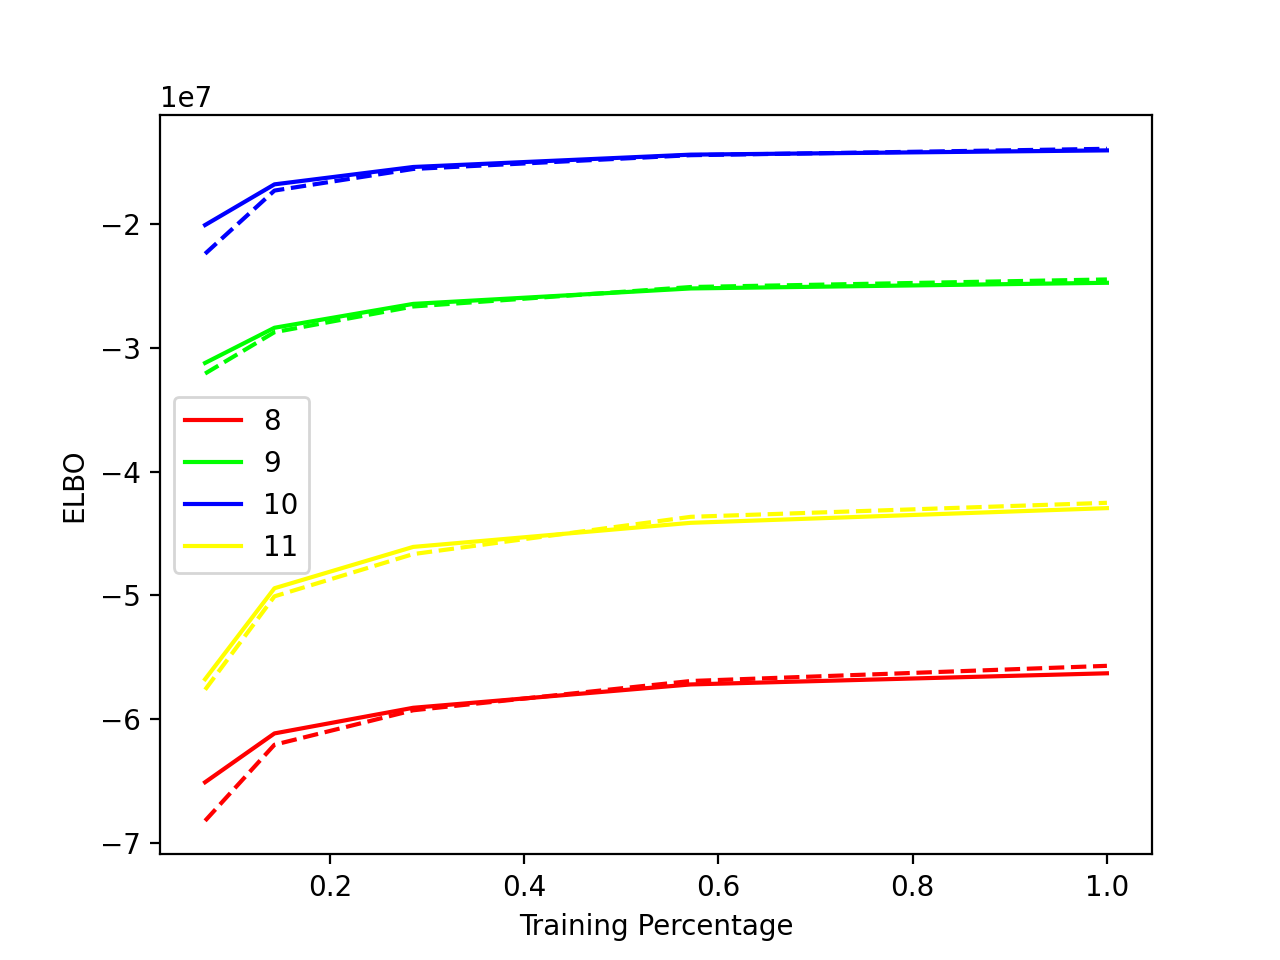

<IPython.core.display.Javascript object>


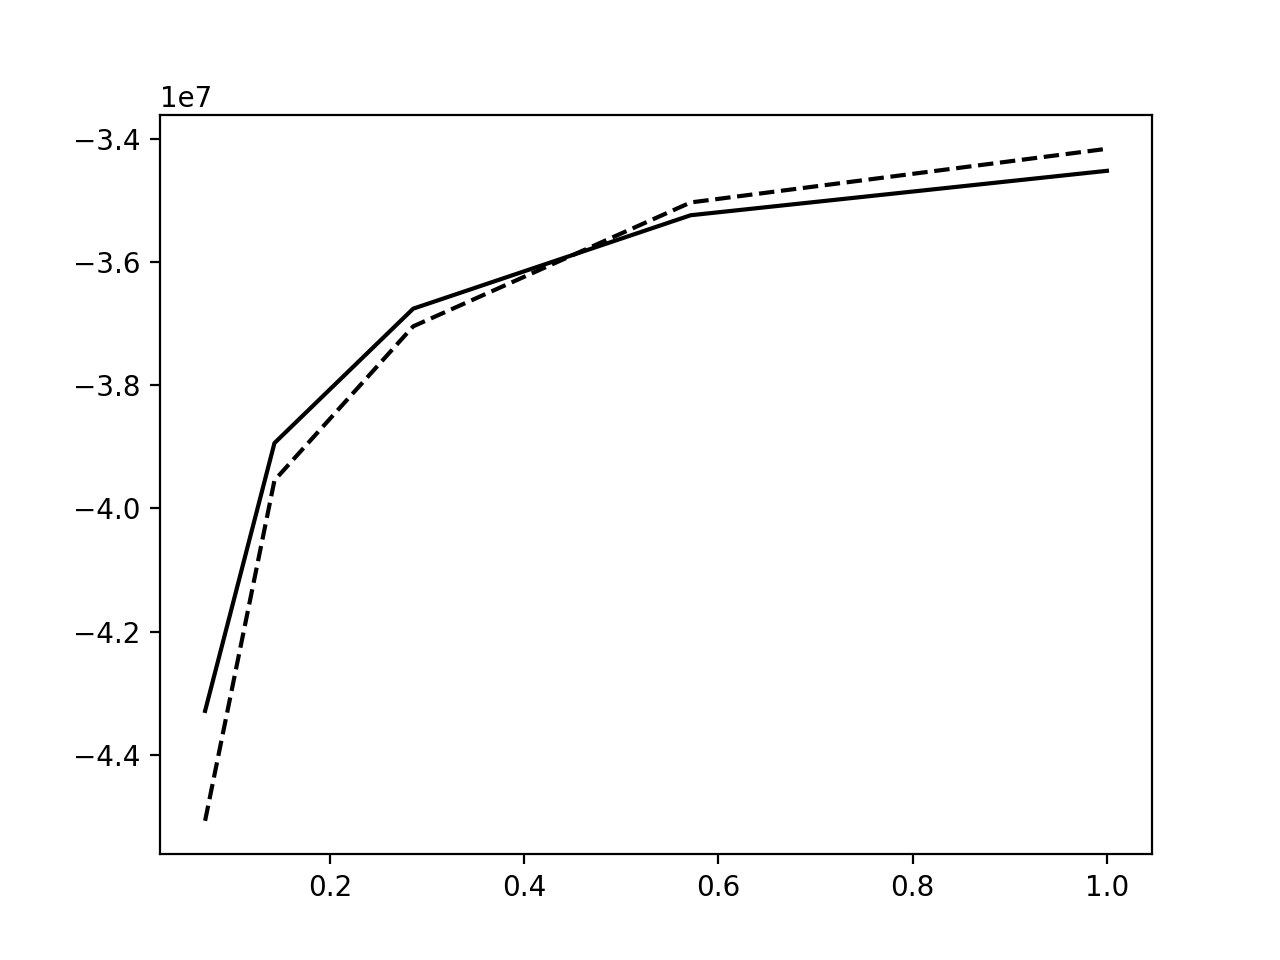

In [23]:
plt.figure()
ax = plt.subplot(1,1,1)
for s_i, subj in enumerate(eval_subjs):
    plt.plot(tq_fracs, comb_rs[0][:, s_i], '-', color=subj_clrs[s_i])
plt.legend(eval_subjs)
plt.xlabel('Training Percentage')
plt.ylabel('ELBO')

for s_i, subj in enumerate(eval_subjs):
    plt.plot(tq_fracs, ind_rs[0][:, s_i], '--', color=subj_clrs[s_i])
#ax.set_ylim([0, 1])

plt.figure()
plt.plot(tq_fracs, comb_avg, 'k-')
plt.plot(tq_fracs, ind_avg, 'k--')